This project is to design Feature Store with a ML Pipeline.
1. Use athletes.csv
2. Setup a ML pipeline in any MLOps platform of your choice.
3. Use a feature store with the ML Pipeline.
4. Load your data and create features with different version.
5. Run experiments with the ML pipeline and feature store
1. Create 2 different versions of features
2. Train an algorithm with the 2 feature versions (do not use AutoML to select the algorithms)
3. Train same algorithm with 2 different set of hyperparameters and 2 feature versions (so 4 combinations)
6. Compare the results of the different experiments both quantitatively (model metrics) and qualitatively (model plots).
7. Compare the carbon emissions for the different experiments.

I used ChatGTP 4o to help me understand key concepts and debug codes.

### Load Data

In [0]:
# Load the Delta table into a Spark DataFrame
athletes_df = spark.table("workspace.default.athletes")

# Preview the data
athletes_df.limit(10).display()

athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,null,null,null,null,null,null,null,220.0,null,400.0,305.0,null,null,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts|,I played youth or high school level sports|I regularly play recreational sports|,I began CrossFit with a coach (e.g. at an affiliate)|I have attended one or more specialty courses|I have had a life changing experience due to CrossFit|,I do multiple workouts in a day 2x a week|,4+ years|
3517.0,Derek Abdella,null,null,null,Male,42.0,70.0,190.0,null,null,null,null,0.0,null,null,null,null,null,null,null,null,I have a coach who determines my programming|I record my workouts|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affiliate)|I have attended one or more specialty courses|I have had a life changing experience due to CrossFit|,I do multiple workouts in a day 2x a week|,4+ years|
4691.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,null,211.0,645.0,300.0,null,196.0,null,null,245.0,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts|,I played youth or high school level sports|,I began CrossFit by trying it alone (without a coach)|I began CrossFit with a coach (e.g. at an affiliate)|I have completed the CrossFit Level 1 certificate course|I have attended one or more specialty courses|I have had a life changing experience due to CrossFit|I train other people|,I usually only do 1 workout a day|,4+ years|
5286.0,Bryce Abbey,null,null,null,Male,32.0,65.0,149.0,206.0,465.0,null,1053.0,null,null,1081.0,205.0,150.0,null,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I incorporate CrossFit.com workouts|I write my own programming|I record my workouts|,I played college sports|,I began CrossFit by trying it alone (without a coach)|I have completed the CrossFit Level 1 certificate course|I train other people|,I usually only do 1 workout a day|I strictly schedule my rest days|,1-2 years|
6491.0,Jason Abney,null,null,null,Male,37.0,73.0,230.0,null,null,null,null,null,null,null,265.0,200.0,435.0,414.0,null,I eat strict Paleo|,I workout mostly at a CrossFit Affiliate|I record my workouts|,I played youth or high school level sports|,I began CrossFit by trying it alone (without a coach)|I have completed the CrossFit Level 1 certificate course|I have had a life changing experience due to CrossFit|I train other people|,I usually only do 1 workout a day|I typically rest 4 or more days per month|,4+ years|
6610.0,Anthony Abeel,South Central,Get Lifted,Get Lifted CrossFit,Male,21.0,72.0,175.0,null,null,null,null,0.0,null,null,0.0,0.0,0.0,0.0,0.0,I eat quality foods but don't measure the amount|I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affiliate)|I have completed the CrossFit Level 1 certificate course|I have had a life changing experience due to CrossFit|I train other people|,I do multiple workouts in a day 3+ times a week|I typically rest fewer than 4 days per month|,2-4 years|
7268.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
7463.0,Tye Abell,null,null,null,Male,30.0,72.0,175.0,null,null,null,null,0.0,null,null,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null
8242.0,Ryan Achilles,nul

### Data Cleaning

In [0]:
from pyspark.sql.functions import col, when
import numpy as np

# Step 1: Drop rows with nulls in required columns
required_cols = ['region', 'age', 'weight', 'height', 'howlong', 'gender', 'eat', 
                 'train', 'background', 'experience', 'schedule', 
                 'deadlift', 'candj', 'snatch', 'backsq']

athletes_df = athletes_df.dropna(subset=required_cols)

# Step 2: Remove outliers and filter values
athletes_df = athletes_df.filter(col('weight') < 1500)
athletes_df = athletes_df.filter(col('gender') != '--')
athletes_df = athletes_df.filter(col('age') >= 18)
athletes_df = athletes_df.filter((col('height') < 96) & (col('height') > 48))

# Special logic for deadlift by gender
athletes_df = athletes_df.filter(
    ((col('deadlift') > 0) & (col('deadlift') <= 1105)) & 
    ~((col('gender') == 'Female') & (col('deadlift') > 636))
)

athletes_df = athletes_df.filter((col('candj') > 0) & (col('candj') <= 395))
athletes_df = athletes_df.filter((col('snatch') > 0) & (col('snatch') <= 496))
athletes_df = athletes_df.filter((col('backsq') > 0) & (col('backsq') <= 1069))

# Step 3: Compute total_lift
athletes_df = athletes_df.withColumn("total_lift", 
    col("candj") + col("snatch") + col("deadlift") + col("backsq")
)

# Drop individual lift columns
athletes_df = athletes_df.drop("candj", "snatch", "deadlift", "backsq")

# Step 4: Clean survey data - handle 'Decline to answer|' values
athletes_df = athletes_df.replace("Decline to answer|", None)

# Drop rows with nulls in survey fields
survey_cols = ['background', 'experience', 'schedule', 'howlong', 'eat']
athletes_df = athletes_df.dropna(subset=survey_cols)

# Display cleaned data
athletes_df.limit(10).display()

athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,pullups,eat,train,background,experience,schedule,howlong,total_lift
21269.0,Erik Acevedo,Southern California,CrossFit Training Yard,CrossFit Training Yard,Male,30.0,71.0,200.0,243.0,null,164.0,null,298.0,null,1584.0,35.0,I eat whatever is convenient|,I workout mostly at a CrossFit Affiliate|I incorporate CrossFit.com workouts|,I played youth or high school level sports|I played college sports|I regularly play recreational sports|,I began CrossFit by trying it alone (without a coach)|I have had a life changing experience due to CrossFit|,I do multiple workouts in a day 1x a week|I typically rest 4 or more days per month|,1-2 years|,1110.0
21685.0,Richard Ablett,Africa,Cape CrossFit Wolfpack,Cape CrossFit,Male,28.0,70.0,176.0,720.0,680.0,null,null,280.0,null,null,27.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affiliate)|I have had a life changing experience due to CrossFit|,I do multiple workouts in a day 1x a week|,2-4 years|,910.0
25464.0,Joe Abruzzo,North East,CrossFit Rapture,CrossFit Rapture,Male,35.0,68.0,225.0,215.0,null,112.0,1594.0,317.0,null,null,24.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I record my workouts|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affiliate)|,I typically rest 4 or more days per month|,2-4 years|,1335.0
43767.0,Brigham Abbott,North Central,RNCF,River North CrossFit,Male,36.0,71.0,199.0,284.0,523.0,154.0,null,379.0,null,null,33.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts|,I played youth or high school level sports|I played college sports|,I began CrossFit with a coach (e.g. at an affiliate)|I have completed the CrossFit Level 1 certificate course|I have had a life changing experience due to CrossFit|I train other people|,I do multiple workouts in a day 3+ times a week|I strictly schedule my rest days|I typically rest 4 or more days per month|,1-2 years|,1354.0
55504.0,Jason Ackerman,North East,Crossfit Soulshine,CrossFit Soulshine,Male,36.0,64.0,155.0,174.0,null,null,null,null,null,null,50.0,I eat strict Paleo|,"I workout mostly at home, work, or a traditional gym|I incorporate CrossFit.com workouts|I record my workouts|",I played youth or high school level sports|I played college sports|I regularly play recreational sports|,I began CrossFit by trying it alone (without a coach)|I have completed the CrossFit Level 1 certificate course|I have attended one or more specialty courses|I have had a life changing experience due to CrossFit|I train other people|,I do multiple workouts in a day 2x a week|I strictly schedule my rest days|I typically rest 4 or more days per month|,4+ years|,1225.0
71305.0,Jerad Abbott,North Central,Koda CrossFit,Koda CrossFit,Male,29.0,69.0,190.0,151.0,null,null,null,null,null,null,null,I eat quality foods but don't measure the amount|I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|,I played college sports|I regularly play recreational sports|,I began CrossFit with a coach (e.g. at an affiliate)|I have had a life changing experience due to CrossFit|,I do multiple workouts in a day 3+ times a week|,6-12 months|,1440.0
2414.0,Bill Adams,South East,First Coast CrossFit,First Coast CrossFit,Male,44.0,69.0,168.0,175.0,615.0,171.0,null,null,85.0,1470.0,34.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affiliate)|,I usually only do 1 workout a day|I typically rest 4 or more days per month|,4+ years|,1270.0
2720.0,Justin Adams,South Central,

### Drop columns with >30% missing values

In [0]:
from pyspark.sql.functions import col, when, count

# Count total rows
total_rows = athletes_df.count()
threshold = total_rows * 0.7

# Count nulls per column
null_counts = athletes_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in athletes_df.columns
]).collect()[0].asDict()

# Keep columns with ≤30% nulls
cols_to_keep = [c for c in null_counts if null_counts[c] <= (total_rows - threshold)]
athletes_df = athletes_df.select(cols_to_keep)

### Impute missing values

In [0]:
from pyspark.sql.functions import col, mean, desc
from pyspark.sql.types import StringType, NumericType

# Identify numeric and categorical columns
numeric_cols = [f.name for f in athletes_df.schema.fields if isinstance(f.dataType, NumericType)]
categorical_cols = [f.name for f in athletes_df.schema.fields if isinstance(f.dataType, StringType)]

# ✅ Impute numeric columns with mean (manual method, no MLlib)
for col_name in numeric_cols:
    mean_val = athletes_df.select(mean(col(col_name))).first()[0]
    if mean_val is not None:
        athletes_df = athletes_df.fillna({col_name: mean_val})

# ✅ Impute categorical columns with mode (most frequent value)
for col_name in categorical_cols:
    mode_val = athletes_df.groupBy(col_name).count().orderBy(desc("count")).first()[0]
    if mode_val is not None:
        athletes_df = athletes_df.fillna({col_name: mode_val})

In [0]:
athletes_df.limit(10).display()

athlete_id,name,region,affiliate,gender,age,height,weight,eat,train,background,experience,schedule,howlong,total_lift
21269.0,Erik Acevedo,Southern California,CrossFit Training Yard,Male,30.0,71.0,200.0,I eat whatever is convenient|,I workout mostly at a CrossFit Affiliate|I incorporate CrossFit.com workouts|,I played youth or high school level sports|I played college sports|I regularly play recreational sports|,I began CrossFit by trying it alone (without a coach)|I have had a life changing experience due to CrossFit|,I do multiple workouts in a day 1x a week|I typically rest 4 or more days per month|,1-2 years|,1110.0
21685.0,Richard Ablett,Africa,Cape CrossFit,Male,28.0,70.0,176.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affiliate)|I have had a life changing experience due to CrossFit|,I do multiple workouts in a day 1x a week|,2-4 years|,910.0
25464.0,Joe Abruzzo,North East,CrossFit Rapture,Male,35.0,68.0,225.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I record my workouts|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affiliate)|,I typically rest 4 or more days per month|,2-4 years|,1335.0
43767.0,Brigham Abbott,North Central,River North CrossFit,Male,36.0,71.0,199.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts|,I played youth or high school level sports|I played college sports|,I began CrossFit with a coach (e.g. at an affiliate)|I have completed the CrossFit Level 1 certificate course|I have had a life changing experience due to CrossFit|I train other people|,I do multiple workouts in a day 3+ times a week|I strictly schedule my rest days|I typically rest 4 or more days per month|,1-2 years|,1354.0
55504.0,Jason Ackerman,North East,CrossFit Soulshine,Male,36.0,64.0,155.0,I eat strict Paleo|,"I workout mostly at home, work, or a traditional gym|I incorporate CrossFit.com workouts|I record my workouts|",I played youth or high school level sports|I played college sports|I regularly play recreational sports|,I began CrossFit by trying it alone (without a coach)|I have completed the CrossFit Level 1 certificate course|I have attended one or more specialty courses|I have had a life changing experience due to CrossFit|I train other people|,I do multiple workouts in a day 2x a week|I strictly schedule my rest days|I typically rest 4 or more days per month|,4+ years|,1225.0
71305.0,Jerad Abbott,North Central,Koda CrossFit,Male,29.0,69.0,190.0,I eat quality foods but don't measure the amount|I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|,I played college sports|I regularly play recreational sports|,I began CrossFit with a coach (e.g. at an affiliate)|I have had a life changing experience due to CrossFit|,I do multiple workouts in a day 3+ times a week|,6-12 months|,1440.0
2414.0,Bill Adams,South East,First Coast CrossFit,Male,44.0,69.0,168.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affiliate)|,I usually only do 1 workout a day|I typically rest 4 or more days per month|,4+ years|,1270.0
2720.0,Justin Adams,South Central,Woodward CrossFit,Male,24.0,68.0,180.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affiliate)|I have completed the CrossFit Level 1 certificate course|I train other people|,I do multiple workouts in a day 3+ times a week|I strictly schedule my rest days|I typically rest 4 or more days p

### Simplify categorical columns with UDFs

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# UDF: simplify_background
@udf(StringType())
def simplify_background(x):
    if x is None:
        return 'Unknown'
    x = x.lower()
    if 'no athletic background' in x:
        return 'No athletic background'
    elif 'college' in x:
        return 'College sports'
    elif 'professional' in x:
        return 'Professional sports'
    elif 'youth or high school' in x:
        return 'Youth/High school sports'
    else:
        return 'Other'

# UDF: simplify_schedule
@udf(StringType())
def simplify_schedule(x):
    if x is None:
        return 'Unknown'
    x = x.lower()
    if 'multiple workouts' in x and '3+' in x:
        return 'High frequency'
    elif 'multiple workouts' in x:
        return 'Medium frequency'
    elif 'only do 1 workout' in x:
        return 'Low frequency'
    elif 'rest 4 or more days' in x:
        return 'Regular rest'
    elif 'rest fewer than 4 days' in x:
        return 'Minimal rest'
    else:
        return 'Other'

# UDF: simplify_experience
@udf(StringType())
def simplify_experience(x):
    if x is None:
        return 'Unknown'
    x = x.lower()
    if 'with a coach' in x:
        return 'Started with coach'
    elif 'alone' in x:
        return 'Started alone'
    else:
        return 'Other'

# Apply UDFs to clean categorical fields
athletes_df = athletes_df.withColumn("background", simplify_background("background"))
athletes_df = athletes_df.withColumn("schedule", simplify_schedule("schedule"))
athletes_df = athletes_df.withColumn("experience", simplify_experience("experience"))

In [0]:
# Apply UDFs to clean categorical fields
athletes_df = athletes_df.withColumn("background", simplify_background("background"))
athletes_df = athletes_df.withColumn("schedule", simplify_schedule("schedule"))
athletes_df = athletes_df.withColumn("experience", simplify_experience("experience"))

In [0]:
# Print value counts (distributions)

athletes_df.groupBy("background").count().orderBy("count", ascending=False).display()
athletes_df.groupBy("schedule").count().orderBy("count", ascending=False).display()
athletes_df.groupBy("experience").count().orderBy("count", ascending=False).display()

background,count
Other,16867
College sports,8225
No athletic background,4228
Professional sports,695


schedule,count
Other,30015


experience,count
Other,23598
Started alone,6417


In [0]:
athletes_df = athletes_df.drop("schedule", "experience")
athletes_df.limit(10).display()

athlete_id,name,region,affiliate,gender,age,height,weight,eat,train,background,howlong,total_lift
21269.0,Erik Acevedo,Southern California,CrossFit Training Yard,Male,30.0,71.0,200.0,I eat whatever is convenient|,I workout mostly at a CrossFit Affiliate|I incorporate CrossFit.com workouts|,College sports,1-2 years|,1110.0
21685.0,Richard Ablett,Africa,Cape CrossFit,Male,28.0,70.0,176.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|,No athletic background,2-4 years|,910.0
25464.0,Joe Abruzzo,North East,CrossFit Rapture,Male,35.0,68.0,225.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I record my workouts|,Other,2-4 years|,1335.0
43767.0,Brigham Abbott,North Central,River North CrossFit,Male,36.0,71.0,199.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts|,College sports,1-2 years|,1354.0
55504.0,Jason Ackerman,North East,CrossFit Soulshine,Male,36.0,64.0,155.0,I eat strict Paleo|,"I workout mostly at home, work, or a traditional gym|I incorporate CrossFit.com workouts|I record my workouts|",College sports,4+ years|,1225.0
71305.0,Jerad Abbott,North Central,Koda CrossFit,Male,29.0,69.0,190.0,I eat quality foods but don't measure the amount|I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|,College sports,6-12 months|,1440.0
2414.0,Bill Adams,South East,First Coast CrossFit,Male,44.0,69.0,168.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|,Other,4+ years|,1270.0
2720.0,Justin Adams,South Central,Woodward CrossFit,Male,24.0,68.0,180.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|I record my workouts|,Other,2-4 years|,1435.0
2818.0,Andy Adams,South Central,Brenham CrossFit,Male,26.0,70.0,197.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I have a coach who determines my programming|,Other,4+ years|,1500.0
6922.0,Daniel Adamson,South West,CrossFit The Point,Male,31.0,67.0,150.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I incorporate CrossFit.com workouts|I write my own programming|I record my workouts|,College sports,2-4 years|,1145.0


In [0]:
print(f"Rows: {athletes_df.count()}, Columns: {len(athletes_df.columns)}")

Rows: 30015, Columns: 13


In [0]:
athletes_df.printSchema()

root
 |-- athlete_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- region: string (nullable = true)
 |-- affiliate: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- eat: string (nullable = true)
 |-- train: string (nullable = true)
 |-- background: string (nullable = true)
 |-- howlong: string (nullable = true)
 |-- total_lift: double (nullable = true)



### Save as Delta Table

In [0]:
# Save to a managed Delta table
athletes_df.write.mode("overwrite").saveAsTable("workspace.default.athletes_cleaned")

In [0]:
# Reload table
athletes_df = spark.table("workspace.default.athletes_cleaned")

### Import and initialize Feature Store client

In [0]:
%pip install databricks-feature-store

INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/722.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.9/722.9 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.9 MB/s eta 0:00:00
   ━━━━━

In [0]:
dbutils.library.restartPython()

In [0]:
from databricks.feature_store import FeatureStoreClient
fs = FeatureStoreClient()

### Create and Register Feature Version 1

In [0]:
# Create a new schema for feature_store

spark.sql("CREATE SCHEMA IF NOT EXISTS workspace.feature_store")

DataFrame[]

In [0]:
# Feature V1: ['age', 'height', 'weight']
features_v1_df = athletes_df.select("athlete_id", "age", "height", "weight")

# Register in Feature Store
fs.create_table(
    name="feature_store.athletes_features_v1",
    primary_keys=["athlete_id"],
    df=features_v1_df,
    description="Feature version 1: basic physical attributes"
)

<FeatureTable: name='workspace.feature_store.athletes_features_v1', table_id='31ed76c8-291b-4d73-8852-c26796c544fe', description='Feature version 1: basic physical attributes', primary_keys=['athlete_id'], partition_columns=[], features=['athlete_id', 'age', 'height', 'weight'], creation_timestamp=1752343455119, online_stores=[], notebook_producers=[], job_producers=[], table_data_sources=[], path_data_sources=[], custom_data_sources=[], timestamp_keys=[], tags={}>

### Create and Register Feature Version 2


In [0]:
# Select version 2 features
features_v2_df = athletes_df.select("athlete_id", "region", "gender", "background", "howlong")

# Register in Feature Store
fs.create_table(
    name="workspace.feature_store.athletes_features_v2",
    primary_keys=["athlete_id"],
    df=features_v2_df,
    description="Feature version 2: demographic and background attributes"
)

<FeatureTable: name='workspace.feature_store.athletes_features_v2', table_id='f7eac6d0-7072-4047-8b35-cc745cb62acc', description='Feature version 2: demographic and background attributes', primary_keys=['athlete_id'], partition_columns=[], features=['athlete_id', 'region', 'gender', 'background', 'howlong'], creation_timestamp=1752350172698, online_stores=[], notebook_producers=[], job_producers=[], table_data_sources=[], path_data_sources=[], custom_data_sources=[], timestamp_keys=[], tags={}>

### Create Label DataFrame (total_lift)

In [0]:
label_df = athletes_df.select("athlete_id", "total_lift")

### Create Training Set for Feature V1

In [0]:
from databricks.feature_store import FeatureLookup

In [0]:
# Create Training Set V1
training_set_v1 = fs.create_training_set(
    df=label_df,
    feature_lookups=[
        FeatureLookup(
            table_name="workspace.feature_store.athletes_features_v1",
            lookup_key="athlete_id"
        )
    ],
    label="total_lift",
    output_mode="spark"
)
train_df_v1 = training_set_v1.load_df()

In [0]:
train_df_v1.printSchema()

root
 |-- athlete_id: double (nullable = true)
 |-- age: double (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- total_lift: double (nullable = true)



### Create Training Set for Feature V2

In [0]:
# Create Training Set V2
training_set_v2 = fs.create_training_set(
    df=label_df,
    feature_lookups=[
        FeatureLookup(
            table_name="workspace.feature_store.athletes_features_v2",
            lookup_key="athlete_id"
        )
    ],
    label="total_lift",
    output_mode="spark"
)
train_df_v2 = training_set_v2.load_df()

In [0]:
train_df_v2.printSchema()

root
 |-- athlete_id: double (nullable = true)
 |-- region: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- background: string (nullable = true)
 |-- howlong: string (nullable = true)
 |-- total_lift: double (nullable = true)



In [0]:
# Encode Categorical Columns in train_df_v2

# My dataset is small enough, convert it to pandas and use sklearn.preprocessing.LabelEncoder

# Convert to pandas
train_df_v2_pd = train_df_v2.toPandas()

from sklearn.preprocessing import LabelEncoder

for col in ["region", "gender", "background", "howlong"]:
    le = LabelEncoder()
    train_df_v2_pd[col + "_idx"] = le.fit_transform(train_df_v2_pd[col])

In [0]:
# Then convert back to Spark

train_df_v2 = spark.createDataFrame(train_df_v2_pd)

In [0]:
train_df_v2.limit(10).display()

athlete_id,region,gender,background,howlong,total_lift,region_idx,gender_idx,background_idx,howlong_idx
21269.0,Southern California,Male,College sports,1-2 years|,1110.0,16,1,0,0
21685.0,Africa,Male,No athletic background,2-4 years|,910.0,0,1,1,4
25464.0,North East,Male,Other,2-4 years|,1335.0,10,1,2,4
43767.0,North Central,Male,College sports,1-2 years|,1354.0,9,1,0,0
55504.0,North East,Male,College sports,4+ years|,1225.0,10,1,0,7
71305.0,North Central,Male,College sports,6-12 months|,1440.0,9,1,0,8
2414.0,South East,Male,Other,4+ years|,1270.0,14,1,2,7
2720.0,South Central,Male,Other,2-4 years|,1435.0,13,1,2,4
2818.0,South Central,Male,Other,4+ years|,1500.0,13,1,2,7
6922.0,South West,Male,College sports,2-4 years|,1145.0,15,1,0,4


### Train a model with both feature versions (without AutoML)

I will use RandomForestRegressor manually — not AutoML — and train:

Feature V1 (['age', 'height', 'weight'])

Feature V2 (['region_idx', 'gender_idx', 'background_idx', 'howlong_idx'])

I will repeat each with 2 hyperparameter sets.

I am in a restricted Databricks runtime (e.g., Free, Serverless, or non-ML Runtime), where RandomForestRegressor from Spark ML is not allowed. Since I already used pandas to encode features for V2, switching to scikit-learn is the most practical solution.

In [0]:
# Convert both training sets to pandas

train_df_v1_pd = train_df_v1.select("age", "height", "weight", "total_lift").toPandas()
train_df_v2_pd = train_df_v2.select(
    "region_idx", "gender_idx", "background_idx", "howlong_idx", "total_lift"
).toPandas()

The function `train_sklearn_model()`:

* Trains a **Random Forest Regressor** using **scikit-learn**
* Splits the input Spark DataFrame (`df`) into training and test sets
* Logs:

  * Model parameters (`max_depth`, `n_estimators`, `features`)
  * Metrics (`RMSE`, `R²`)
  * The trained model
* Uses **MLflow** for full experiment tracking in Databricks
* Returns the trained model and predictions 


In [0]:
#  Define reusable training function (with sklearn + MLflow)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn

def train_sklearn_model(df, features, label, max_depth, n_estimators, run_name):
    X = df[features]
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

    with mlflow.start_run(run_name=run_name):
        model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        rmse = mean_squared_error(y_test, preds, squared=False)
        r2 = r2_score(y_test, preds)

        mlflow.log_params({
            "features": features,
            "max_depth": max_depth,
            "n_estimators": n_estimators
        })
        mlflow.log_metrics({
            "rmse": rmse,
            "r2": r2
        })
        mlflow.sklearn.log_model(model, "rf-model")

        print(f"Run {run_name}: RMSE={rmse:.2f}, R2={r2:.2f}")

        return {
            "Run Name": run_name,
            "Feature Set": "V1" if features == features_v1 else "V2",
            "maxDepth": max_depth,
            "numTrees": n_estimators,
            "RMSE": rmse,
            "R2": r2,
            "y_test": y_test,
            "preds": preds
        }

In [0]:
# Run 4 combinations

# V1 features
features_v1 = ["age", "height", "weight"]

# V2 features
features_v2 = ["region_idx", "gender_idx", "background_idx", "howlong_idx"]

# Run 4 experiments
results = []
results.append(train_sklearn_model(train_df_v1_pd, features_v1, "total_lift", 5, 20, "V1_HP1"))
results.append(train_sklearn_model(train_df_v1_pd, features_v1, "total_lift", 10, 50, "V1_HP2"))
results.append(train_sklearn_model(train_df_v2_pd, features_v2, "total_lift", 5, 20, "V2_HP1"))
results.append(train_sklearn_model(train_df_v2_pd, features_v2, "total_lift", 10, 50, "V2_HP2"))

import pandas as pd
results_df = pd.DataFrame(results)
results_df

2025/07/13 16:02:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-930867b3-553d.cloud.databricks.com/ml/experiments/224962478098570/models/m-646a7c9df31d42b48002029775ef3c2f?o=1640771898437172
2025/07/13 16:02:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run V1_HP1: RMSE=188.07, R2=0.53


2025/07/13 16:02:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-930867b3-553d.cloud.databricks.com/ml/experiments/224962478098570/models/m-86e397f89b07441f81a475a3b40a0016?o=1640771898437172
2025/07/13 16:02:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run V1_HP2: RMSE=185.57, R2=0.54


2025/07/13 16:02:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-930867b3-553d.cloud.databricks.com/ml/experiments/224962478098570/models/m-28b888107661481085bfdb49f0f4e7af?o=1640771898437172
2025/07/13 16:02:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run V2_HP1: RMSE=179.08, R2=0.59


2025/07/13 16:02:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-930867b3-553d.cloud.databricks.com/ml/experiments/224962478098570/models/m-d4aaf65a49ed4324b9a67fbd696d664c?o=1640771898437172
2025/07/13 16:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run V2_HP2: RMSE=178.85, R2=0.59


,Run Name,Feature Set,maxDepth,numTrees,RMSE,R2,y_test,preds
0,V1_HP1,V1,5,20,188.071606,0.527310,27655 490.0 25760 940.0 5068 1185....,"[637.9022106695164, 1045.0214706723073, 1179.3..."
1,V1_HP2,V1,10,50,185.565572,0.539823,27655 490.0 25760 940.0 5068 1185....,"[656.4537427135635, 987.9542845700485, 1249.45..."
2,V2_HP1,V2,5,20,179.075820,0.587720,27655 550.0 25760 611.0 5068 1255....,"[615.3022967464735, 615.3022967464735, 1175.87..."
3,V2_HP2,V2,10,50,178.845879,0.588778,27655 550.0 25760 611.0 5068 1255....,"[656.7848962413841, 648.0528215621927, 1165.83..."


Summary: 

Feature set V2 outperformed V1 — better RMSE and R².

Increasing depth/trees in V1 helped slightly; not much difference in V2, suggesting it saturated.

### Compare the results of the different experiments both quantitatively (model metrics) and qualitatively (model plots)

In [0]:
import pandas as pd

results_df = pd.DataFrame([{k: v for k, v in r.items() if k in ["Run Name", "Feature Set", "maxDepth", "numTrees", "RMSE", "R2"]} for r in results])
display(results_df)

Run Name,Feature Set,maxDepth,numTrees,RMSE,R2
V1_HP1,V1,5,20,188.0716055595571,0.5273095146227538
V1_HP2,V1,10,50,185.56557197714378,0.5398226852232357
V2_HP1,V2,5,20,179.07581952158418,0.5877200845943056
V2_HP2,V2,10,50,178.84587874206252,0.5887781738644156


In [0]:
# Save and Log Plots

import matplotlib.pyplot as plt
import os
import tempfile
import mlflow
from matplotlib.figure import Figure

def save_and_log_plot(fig: Figure, artifact_name: str):
    with tempfile.TemporaryDirectory() as tmpdir:
        file_path = os.path.join(tmpdir, f"{artifact_name}.png")
        fig.savefig(file_path)
        mlflow.log_artifact(file_path, artifact_path="plots")

In [0]:
# I'll plot Predicted vs. Actual for each run to visualize performance.

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import mlflow
import tempfile
import os

def plot_predictions(y_true, y_pred, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    ax.set_xlabel("True Total Lift")
    ax.set_ylabel("Predicted Total Lift")
    ax.set_title(title)
    ax.grid(True)

    # Log and display
    save_and_log_plot(fig, artifact_name=title.replace(" ", "_"))
    plt.show()
    plt.close(fig)

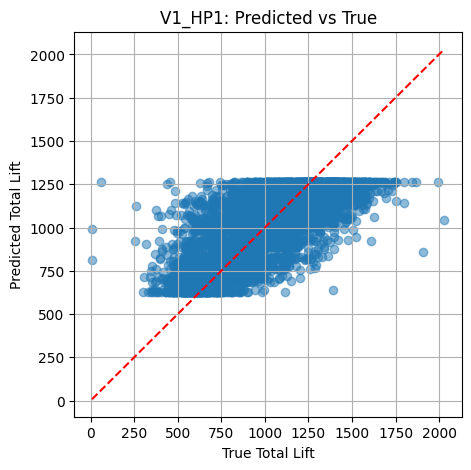

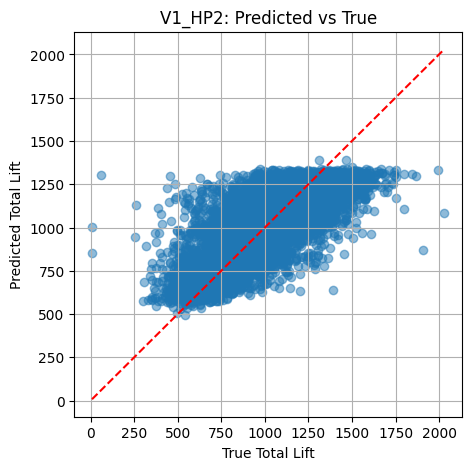

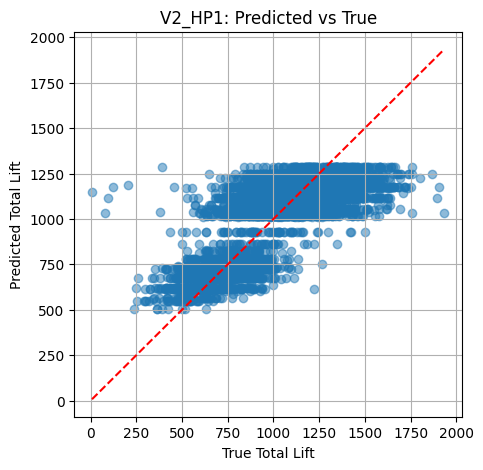

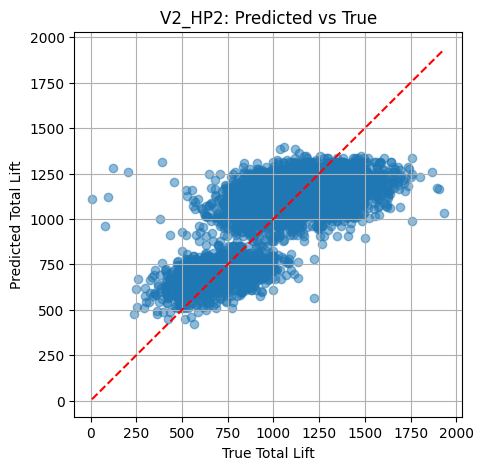

In [0]:
for r in results:
    plot_predictions(r["y_test"], r["preds"], f"{r['Run Name']}: Predicted vs True")

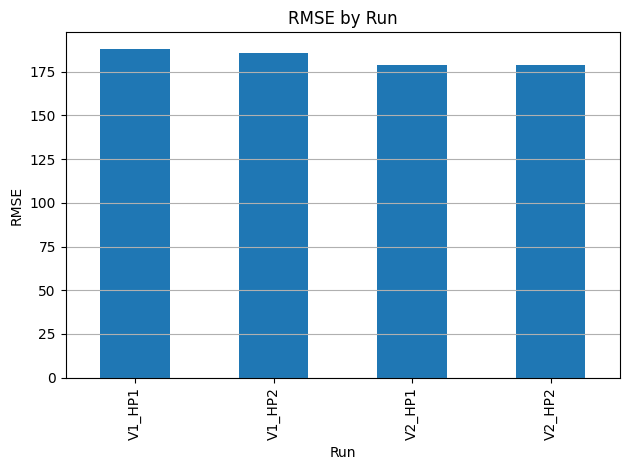

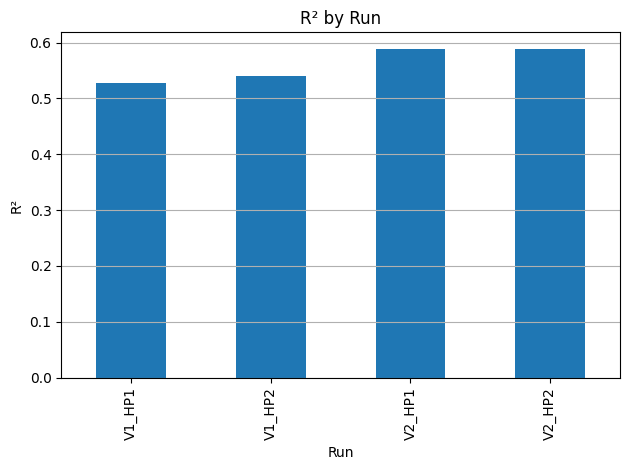

In [0]:
# RMSE bar plot
fig_rmse, ax_rmse = plt.subplots()
results_df.plot(x="Run Name", y="RMSE", kind="bar", legend=False, title="RMSE by Run", ylabel="RMSE", xlabel="Run", ax=ax_rmse)
ax_rmse.grid(axis='y')
plt.tight_layout()
plt.show()
save_and_log_plot(fig_rmse, "rmse_bar_plot")
plt.close(fig_rmse)

# R2 bar plot
fig_r2, ax_r2 = plt.subplots()
results_df.plot(x="Run Name", y="R2", kind="bar", legend=False, title="R² by Run", ylabel="R²", xlabel="Run", ax=ax_r2)
ax_r2.grid(axis='y')
plt.tight_layout()
plt.show()
save_and_log_plot(fig_r2, "r2_bar_plot")
plt.close(fig_r2)

### Compare the carbon emissions for the different experiments

Compare the carbon emissions for four experiments in Databricks using CodeCarbon, a lightweight package for tracking the environmental impact of ML workloads.

In [0]:
# Install CodeCarbon

%pip install codecarbon


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/610.1 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.4 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.0
    Not uninstalling psutil at /databricks/python3/lib/python3.11/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-e19f1c5b-5876-466c-a06e-46e9c83cc49b
    Can't uninstall 'psutil'. No files were found to uninstall.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from codecarbon import EmissionsTracker

In [0]:
import codecarbon
codecarbon.__file__

'/local_disk0/.ephemeral_nfs/envs/pythonEnv-e19f1c5b-5876-466c-a06e-46e9c83cc49b/lib/python3.11/site-packages/codecarbon/__init__.py'

my CodeCarbon path is:

/local_disk0/.ephemeral_nfs/envs/pythonEnv-e19f1c5b-5876-466c-a06e-46e9c83cc49b/lib/python3.11/site-packages/codecarbon

In [0]:
from codecarbon import EmissionsTracker
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import mlflow
import mlflow.sklearn

def train_with_emissions_tracking(X_train, X_test, y_train, y_test, features, max_depth, n_estimators, run_name):
    # 💡 Prevent overlapping MLflow runs
    if mlflow.active_run():
        mlflow.end_run()

    tracker = EmissionsTracker(project_name=run_name, output_dir="emissions", output_file=f"{run_name}_emissions.csv")
    tracker.start()

    model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    emissions = tracker.stop()

    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    mlflow.start_run(run_name=run_name)
    mlflow.log_params({
        "features": features,
        "max_depth": max_depth,
        "n_estimators": n_estimators
    })
    mlflow.log_metrics({
        "rmse": rmse,
        "r2": r2,
        "emissions_kg": emissions or 0
    })
    mlflow.sklearn.log_model(model, "rf-model")
    mlflow.end_run()

    print(f"{run_name} → RMSE: {rmse:.2f}, R2: {r2:.2f}, Emissions: {emissions:.6f} kg CO2eq")
    return model, preds, emissions

In [0]:
# Re-run All 4 Experiments with Emission Tracking

from sklearn.model_selection import train_test_split

# V1
X1 = train_df_v1_pd[features_v1]
y1 = train_df_v1_pd["total_lift"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# V2
X2 = train_df_v2_pd[features_v2]
y2 = train_df_v2_pd["total_lift"]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [0]:
# Run 4 tracked trainings

results_emissions = []

# Run 4 experiments
model_v1_hp1, preds_v1_hp1, e1 = train_with_emissions_tracking(X1_train, X1_test, y1_train, y1_test, features_v1, 5, 20, "V1_HP1_EM")
results_emissions.append({"Run Name": "V1_HP1", "Feature Set": "V1", "maxDepth": 5, "numTrees": 20, "Emissions (kg)": e1})

model_v1_hp2, preds_v1_hp2, e2 = train_with_emissions_tracking(X1_train, X1_test, y1_train, y1_test, features_v1, 10, 50, "V1_HP2_EM")
results_emissions.append({"Run Name": "V1_HP2", "Feature Set": "V1", "maxDepth": 10, "numTrees": 50, "Emissions (kg)": e2})

model_v2_hp1, preds_v2_hp1, e3 = train_with_emissions_tracking(X2_train, X2_test, y2_train, y2_test, features_v2, 5, 20, "V2_HP1_EM")
results_emissions.append({"Run Name": "V2_HP1", "Feature Set": "V2", "maxDepth": 5, "numTrees": 20, "Emissions (kg)": e3})

model_v2_hp2, preds_v2_hp2, e4 = train_with_emissions_tracking(X2_train, X2_test, y2_train, y2_test, features_v2, 10, 50, "V2_HP2_EM")
results_emissions.append({"Run Name": "V2_HP2", "Feature Set": "V2", "maxDepth": 10, "numTrees": 50, "Emissions (kg)": e4})

[codecarbon WARNING @ 16:14:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 16:14:22] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 16:14:22] [setup] RAM Tracking...
[codecarbon INFO @ 16:14:23] [setup] CPU Tracking...
[codecarbon WARNING @ 16:14:23] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 16:14:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:14:23] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 16:14:23] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 16:14:23] [setup] GPU Tracking...
[codecarbon INFO @ 16:14:23] No GPU found.
[codecarbon INFO @ 16:14:23] The 

V1_HP1_EM → RMSE: 188.07, R2: 0.53, Emissions: 0.000003 kg CO2eq


[codecarbon INFO @ 16:14:30] Emissions data (if any) will be saved to file /Workspace/Users/gongl@uchicago.edu/emissions/V1_HP2_EM_emissions.csv
[codecarbon INFO @ 16:14:31] Energy consumed for RAM : 0.000001 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 16:14:31] Delta energy consumed for CPU with cpu_load : 0.000009 kWh, power : 24.395 W
[codecarbon INFO @ 16:14:31] Energy consumed for All CPU : 0.000009 kWh
[codecarbon INFO @ 16:14:31] 0.000010 kWh of electricity used since the beginning.
2025/07/13 16:14:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-930867b3-553d.cloud.databricks.com/ml/experiments/224962478098570/models/m-ba8ee5b73bbe4a1eba110df3adc4779f?o=1640771898437172
2025/07/13 16:14:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[codecarbon WARNING @ 16:14:36] Multiple 

V1_HP2_EM → RMSE: 185.57, R2: 0.54, Emissions: 0.000007 kg CO2eq


[codecarbon INFO @ 16:14:36] Emissions data (if any) will be saved to file /Workspace/Users/gongl@uchicago.edu/emissions/V2_HP1_EM_emissions.csv
[codecarbon INFO @ 16:14:37] Energy consumed for RAM : 0.000001 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 16:14:38] Delta energy consumed for CPU with cpu_load : 0.000004 kWh, power : 21.930000000000007 W
[codecarbon INFO @ 16:14:38] Energy consumed for All CPU : 0.000004 kWh
[codecarbon INFO @ 16:14:38] 0.000004 kWh of electricity used since the beginning.
2025/07/13 16:14:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-930867b3-553d.cloud.databricks.com/ml/experiments/224962478098570/models/m-5ad6c4bd79334258bec18eb76d81f3aa?o=1640771898437172
2025/07/13 16:14:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[codecarbon WARNING @ 16:14:4

V2_HP1_EM → RMSE: 179.08, R2: 0.59, Emissions: 0.000003 kg CO2eq


[codecarbon INFO @ 16:14:43] Emissions data (if any) will be saved to file /Workspace/Users/gongl@uchicago.edu/emissions/V2_HP2_EM_emissions.csv
[codecarbon INFO @ 16:14:44] Energy consumed for RAM : 0.000001 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 16:14:44] Delta energy consumed for CPU with cpu_load : 0.000011 kWh, power : 35.02 W
[codecarbon INFO @ 16:14:44] Energy consumed for All CPU : 0.000011 kWh
[codecarbon INFO @ 16:14:44] 0.000012 kWh of electricity used since the beginning.
2025/07/13 16:14:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-930867b3-553d.cloud.databricks.com/ml/experiments/224962478098570/models/m-7946f224187244e7ae37eacc0ac7b25e?o=1640771898437172
2025/07/13 16:14:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


V2_HP2_EM → RMSE: 178.85, R2: 0.59, Emissions: 0.000008 kg CO2eq


In [0]:
import pandas as pd

emissions_df = pd.DataFrame(results_emissions)
display(emissions_df)

Run Name,Feature Set,maxDepth,numTrees,Emissions (kg)
V1_HP1,V1,5,20,2.567269422173553E-6
V1_HP2,V1,10,50,6.886965580704039E-6
V2_HP1,V2,5,20,2.9064320210684558E-6
V2_HP2,V2,10,50,7.888878725876327E-6


### Plot + Log Emissions Chart

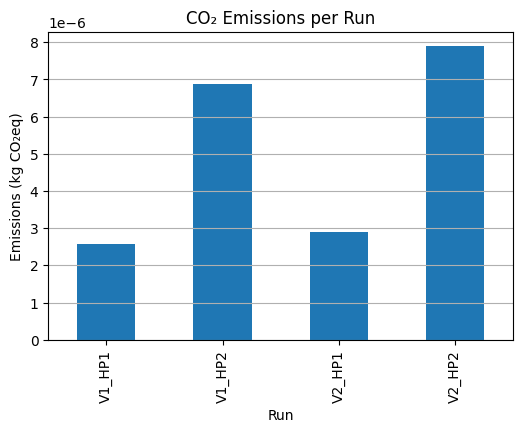

In [0]:
import matplotlib.pyplot as plt
import tempfile
import os
import mlflow
from matplotlib.figure import Figure

# Utility function to save and log plot to MLflow
def save_and_log_plot(fig: Figure, artifact_name: str):
    with tempfile.TemporaryDirectory() as tmpdir:
        file_path = os.path.join(tmpdir, f"{artifact_name}.png")
        fig.savefig(file_path)
        mlflow.log_artifact(file_path, artifact_path="plots")

# Create and log emissions plot
fig, ax = plt.subplots(figsize=(6, 4))
emissions_df.plot(x="Run Name", y="Emissions (kg)", kind="bar", title="CO₂ Emissions per Run", legend=False, ax=ax)
ax.set_ylabel("Emissions (kg CO₂eq)")
ax.set_xlabel("Run")
ax.grid(axis='y')

# Save and log to MLflow
save_and_log_plot(fig, artifact_name="emissions_per_run")

# Show in notebook
plt.show()
plt.close(fig)

Summary:

* **V2\_HP2** (Feature Set V2, Depth 10, 50 trees) had the **highest emissions**.
* **V1\_HP1** (Feature Set V1, Depth 5, 20 trees) had the **lowest emissions**.
* Emissions **increase** with **model complexity** (higher `maxDepth` and `numTrees`).
* Feature Set **V2** tends to use **slightly more energy** than V1 at the same hyperparameter settings.

**Insight**: Simpler models (shallower trees, fewer estimators) are more energy-efficient.
